In [1]:
from evaluate_sdfdqn import *

In [2]:
# experiment configuration #
num_blocks = 3
max_blocks = 6
threshold = 2.5
max_steps = 20
gpu = 0
num_trials = 10
model = 'rulebased'
adj_ver = 0
selfloop = False
graph_normalize = False
resize = True
separate = False
bias = False
clip_sdf = False
round_sdf = False
depth = False
tracker = False
convex_hull = False
segmentation = False

In [3]:
# SDF module & Environment #
sdf_module = SDFModule(rgb_feature=True, resnet_feature=True, convex_hull=convex_hull, 
            binary_hole=True, using_depth=depth, tracker=False, resize=resize)
ur5robot = UR5Robot()
env = RealSDFEnv(ur5robot, sdf_module, num_blocks=num_blocks)

/home/dof6/Desktop/hogun_ur5/realrobot/../UnseenObjectClustering/fcn/config.py:439: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [4]:
def show_img(imgs, vmin=0.56, vmax=0.6):
    color, depth = imgs
    color = sdf_module.remove_background(color)
    plt.subplot(1, 2, 1)
    plt.imshow(color)
    plt.subplot(1, 2, 2)
    plt.imshow(depth, vmin=vmin, vmax=vmax)

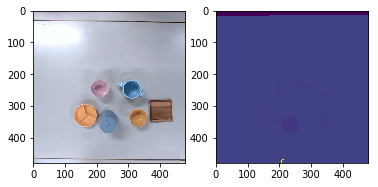

In [5]:
# 1. Reset Robot Arm & Set Background Image#
background_img, _ = env.reset()
sdf_module.set_background(background_img[1])
#env.ur5.realsense = RealSenseSensor("141322252613")
#env.ur5.realsense.frames(spatial=True, hole_filling=True, temporal=True)

show_img(background_img, 0, 3)

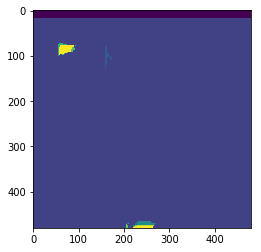

In [5]:
# 1. Reset Robot Arm & Set Background Image#
_ = env.reset()
sdf_module.load_background()
#env.ur5.realsense = RealSenseSensor("141322252613")
#env.ur5.realsense.frames(spatial=True, hole_filling=True, temporal=True)

plt.imshow(sdf_module.depth_bg, vmin=0, vmax=3)

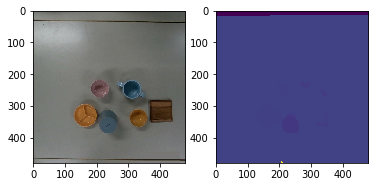

In [6]:
# 2. Set Goal Scene #
env.set_goals()
show_img(env.goals, 0, 3)

In [7]:
# 3. Init Scene #
(state_img, goal_img) = env.reset()

sdf_st, sdf_raw, feature_st, masks_st = sdf_module.get_sdf_features_with_ucn(state_img[0], state_img[1], env.num_blocks, clip=clip_sdf)
sdf_g_b, _, feature_g, masks_g = sdf_module.get_sdf_features_with_ucn(goal_img[0], goal_img[1], env.num_blocks, clip=clip_sdf)
sdf_g = sdf_module.make_round_sdf(sdf_g_b) if round_sdf else sdf_g_b

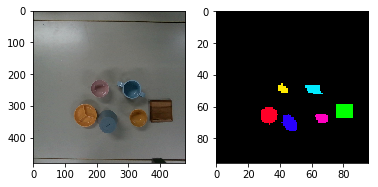

In [8]:
# Visualize Goal Scene #
sdf_res = 96
cm = pylab.get_cmap('gist_rainbow')

vis_g = norm_npy(0*sdf_g_b + 2*(sdf_g_b>0).astype(float))
goal_sdfs = np.zeros([sdf_res, sdf_res, 3])
for _s in range(len(vis_g)):
    goal_sdfs += np.expand_dims(vis_g[_s], 2) * np.array(cm(_s/5)[:3])

plt.subplot(1, 2, 1)
plt.imshow(goal_img[0])
plt.subplot(1, 2, 2)
plt.imshow(norm_npy(goal_sdfs))

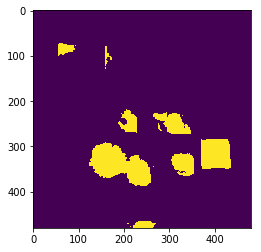

In [13]:
plt.imshow((sdf_module.depth_bg - state_img[1])>0.005)

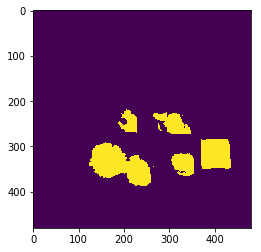

In [47]:
delta = (sdf_module.depth_bg - state_img[1])>0.005
delta[465:, 200:280] = 0
delta[70:110, 50:95] = 0
delta[80:130, 155:175] = 0
plt.imshow(delta)

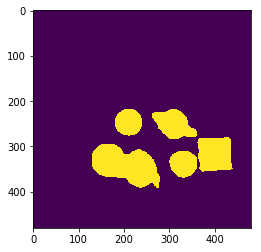

In [10]:
m, l = sdf_module.eval_ucn(state_img[0], state_img[1])
plt.imshow(np.sum(m, 0))

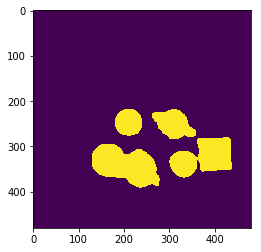

In [11]:
m, l = sdf_module.eval_ucn(goal_img[0], goal_img[1])
plt.imshow(np.sum(m, 0))

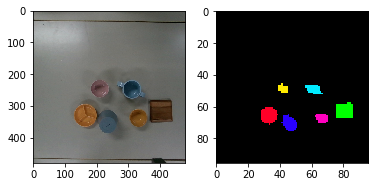

In [12]:
# Visualize Current Scene #
vis_st = norm_npy(0*sdf_st + 2*(sdf_st>0).astype(float))
current_sdfs = np.zeros([sdf_res, sdf_res, 3])
for _s in range(len(vis_st)):
    current_sdfs += np.expand_dims(vis_st[_s], 2) * np.array(cm(_s/5)[:3])

plt.subplot(1, 2, 1)
plt.imshow(state_img[0])
plt.subplot(1, 2, 2)
plt.imshow(norm_npy(current_sdfs))

In [11]:
# 4. Find Matching #
matching = sdf_module.object_matching(feature_st, feature_g)
sdf_st_align = sdf_module.align_sdf(matching, sdf_st, sdf_g)
sdf_raw = sdf_module.align_sdf(matching, sdf_raw, np.zeros([sdf_g.shape[0], *sdf_raw.shape[1:]]))

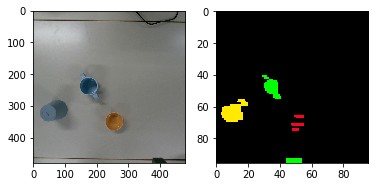

In [12]:
# Visualize Current Scene #
vis_c = norm_npy(0*sdf_st_align + 2*(sdf_st_align>0).astype(float))
current_sdfs = np.zeros([sdf_res, sdf_res, 3])
for _s in range(len(vis_c)):
    current_sdfs += np.expand_dims(vis_c[_s], 2) * np.array(cm(_s/5)[:3])

plt.subplot(1, 2, 1)
plt.imshow(state_img[0])
plt.subplot(1, 2, 2)
plt.imshow(norm_npy(current_sdfs))

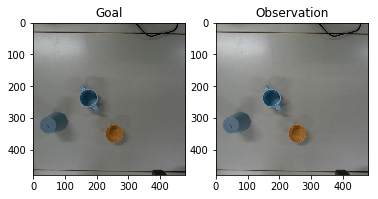

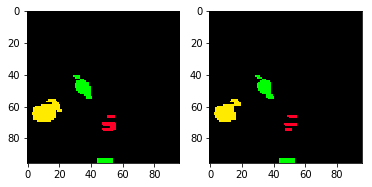

In [13]:
plt.subplot(1, 2, 1)
plt.imshow(goal_img[0])
plt.title('Goal')
plt.subplot(1, 2, 2)
plt.imshow(state_img[0])
plt.title('Observation')
plt.show()

plt.subplot(1, 2, 1)
plt.imshow(norm_npy(goal_sdfs))
plt.subplot(1, 2, 2)
plt.imshow(norm_npy(current_sdfs))
plt.show()

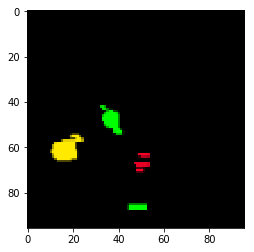

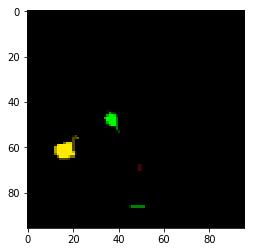

In [30]:
resized = resize_pad(current_sdfs.transpose([2, 0, 1])).transpose([1, 2, 0])
plt.imshow(norm_npy(resized))
plt.show()
kernel = np.ones((3, 3), np.uint8)
eroded = cv2.erode(resized, kernel)
plt.imshow(norm_npy(eroded))

In [38]:
current_sdfs.shape

(96, 96, 3)

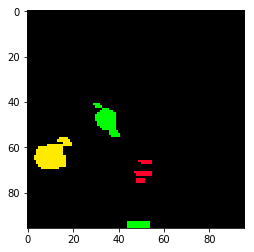

In [40]:
plt.imshow(current_sdfs)

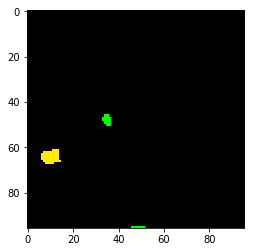

In [39]:
kernel = np.ones((5, 5), np.uint8)
eroded = cv2.erode(current_sdfs, kernel)
plt.imshow(norm_npy(eroded))

(3, 96, 96)


/home/dof6/Desktop/hogun_ur5/realrobot/evaluate_sdfdqn.py:30: RuntimeWarning: invalid value encountered in true_divide
  return positive / positive.max()


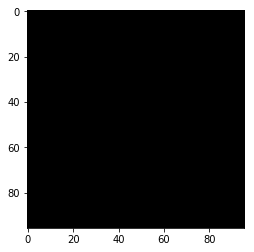

In [42]:
print(current_sdfs.transpose([2, 0, 1]).shape)
kernel = np.ones((5, 5), np.uint8)
eroded = cv2.erode(current_sdfs.transpose([2, 0, 1]), kernel)
plt.imshow(norm_npy(eroded).transpose([1,2,0]))

In [34]:
eroded.shape

(96, 96, 3)

In [23]:
# 5. Get Action #
action, q_map = get_rulebased_action(env, max_blocks, None, state_img[1], sdf_raw, \
                    [sdf_st_align, sdf_g], epsilon=0.1, with_q=True, \
                    target_res=sdf_res)
print(action)

[2, 2.0]


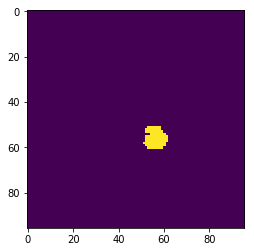

In [29]:
plt.imshow(sdf_st_align[1]>0)

In [34]:
action = [2, 0]

In [35]:
# 6. Pushing #
(next_state_img, _), reward, done, info = env.step(action, sdf_st_align, sdf_g)

Plan to the Pre-push Pose: 48
Plan to the Starting Pose: 8
Plan to the Ending Pose: 8


In [10]:
ur5robot.ROBOT_INIT_POS

[0, -0.15, 0.65]

In [25]:
ur5robot.ROBOT_INIT_POS = [0, -0.15, 0.65]

In [16]:
x, y, z, w = euler2quat([np.pi, 0, 0])
print(x, y, z, w)
print(quat2mat([x, y, z, w]))
ur5robot.ROBOT_INIT_QUAT = [x, y, z, w]
ur5robot.ROBOT_INIT_ROTATION = quat2mat([x, y, z ,w])

1.0 0.0 0.0 6.123233995736766e-17
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -9.99999881e-01 -1.22464672e-16]
 [ 0.00000000e+00  1.22464672e-16 -9.99999881e-01]]


In [24]:
x, y, z, w = euler2quat([np.pi * 7/8, 0, 0])
print(x, y, z, w)
print(quat2mat([x, y, z, w]))
ur5robot.ROBOT_INIT_QUAT = [x, y, z, w]
ur5robot.ROBOT_INIT_ROTATION = quat2mat([x, y, z ,w])

0.9807852804032304 0.0 0.0 0.19509032201612833
[[ 1.          0.          0.        ]
 [ 0.         -0.92387974 -0.38268349]
 [ 0.          0.38268349 -0.92387974]]


In [6]:
m = np.load('../ur5_mujoco/workspace_mask_480.npy')
m.shape

(480, 480)

In [13]:
ur5robot.ROBOT_INIT_POS = [0, -0.5, 0.68]

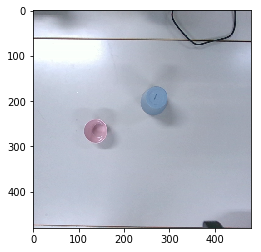

In [14]:
color_raw, depth_raw = env.ur5.get_view_at_ws_init()
color, depth = env.crop_resize(color_raw, depth_raw)
plt.imshow(color)

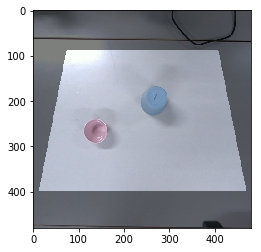

In [15]:
color[~m] = color[~m] * 0.5
plt.imshow(color)

In [48]:
np.pad(color, [[1, 1], [1, 1], [0, 0]]).shape

(482, 482, 3)

In [36]:
np.pad(color, [[1, 1], [1, 1], [0, 0]], mode="").shape

(482, 482, 3)

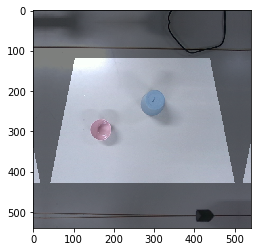

In [46]:
plt.imshow(np.pad(color, [[30, 30], [30, 30], [0, 0]], mode='reflect'))

In [27]:
plt.imshow(np.pad(color, [[4, 4], [4, 4]]))#, mode='wrap'))

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (2,2) and requested shape (3,2)

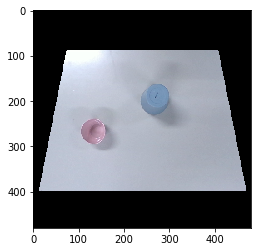

In [8]:
color[~m] = [0, 0, 0]
plt.imshow(color)

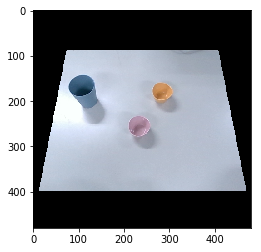

In [38]:
color[~m] = [0, 0, 0]
plt.imshow(color)

In [29]:
env.ur5.pixel2pos(env.real_depth, [200, 100])

array([ 0.40675103, -0.77990157, -0.0148891 ])

In [33]:
env.ur5.move_to_pose([0.0, -0.58, 0.25])

plan: 
  header: 
    seq: 0
    stamp: 
      secs: 0
      nsecs:         0
    frame_id: "/world"
  joint_names: 
    - shoulder_pan_joint
    - shoulder_lift_joint
    - elbow_joint
    - wrist_1_joint
    - wrist_2_joint
    - wrist_3_joint
  points: 
    - 
      positions: [-1.3138302008258265, -0.4295557180987757, 0.24151039123535156, -1.3886969725238245, 4.729316234588623, 3.4863526821136475]
      velocities: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
      accelerations: [-0.21382969878140004, 0.0, 0.0, 0.0, 0.0, 0.0]
      effort: []
      time_from_start: 
        secs: 0
        nsecs:         0
    - 
      positions: [-1.3221557764228864, -0.4915244608522372, 0.36453022388576184, -1.4497282108245222, 4.729624913510341, 3.479223027113687]
      velocities: [-0.06172797607393307, -0.3715070478821352, 0.7288050863902091, -0.35713541107179686, 0.0017507872475398538, -0.05469580945338005]
      accelerations: [-0.3461578839543462, -1.6219799303446385, 3.125430907752421, -1.5024579852276

In [34]:
# 3. Init Scene #
(state_img, goal_img) = env.reset()

sdf_st, sdf_raw, feature_st = sdf_module.get_sdf_features_with_ucn(state_img[0], state_img[1], env.num_blocks, clip=clip_sdf)
sdf_g_b, _, feature_g = sdf_module.get_sdf_features_with_ucn(goal_img[0], goal_img[1], env.num_blocks, clip=clip_sdf)
sdf_g = sdf_module.make_round_sdf(sdf_g_b) if round_sdf else sdf_g_b

TypeError: 'NoneType' object is not subscriptable

In [43]:
np.where(sdf_st[0]==sdf_st[0].max())

(array([29]), array([16]))

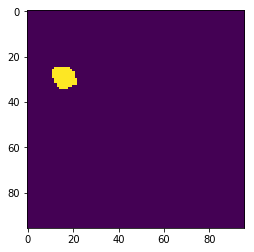

In [41]:
plt.imshow(sdf_st[0]>0)

In [ ]:
env.inverse_raw_pixel(np.array([29, 16]), env.midx, env.midy,